In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

# 1. Load dataset

In [3]:
df = pd.read_csv('LoanData.csv.gz', compression='gzip', skiprows=1, error_bad_lines=False)

C:\Users\Suhas\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 2. Exploratory data analysis

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68446771,NaN,7200,7200,7200,36 months,15.77%,252.32,D,D1,Bank Officer Senior Customer Care Spec.,< 1 year,RENT,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,142xx,NY,17.35,0,Jun-2005,680,684,0,59.0,74.0,24,1,5938,69%,43,w,0.0,0.0,...,1,255047,275831,6700,246447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68367009,NaN,14025,14025,14025,60 months,18.49%,359.90,D,D5,accts payable,10+ years,MORTGAGE,39000.0,Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,546xx,WI,18.00,0,Aug-2001,675,679,1,NaN,NaN,12,0,15646,74.9%,21,w,0.0,0.0,...,0,72286,15646,8800,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68585839,NaN,17475,17475,17475,36 months,13.99%,597.17,C,C4,Software Testing Analyst,2 years,RENT,39750.0,Not Verified,Dec-2015,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,604xx,IL,23.58,0,May-2002,695,699,0,27.0,NaN,7,0,10987,52.3%,13,w,0.0,0.0,...,0,50240,32365,21000,29240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Feb-2019,COMPLETE,Jan-2018,4382.0,44.99,12.0
3,68577849,NaN,18000,18000,18000,60 months,11.99%,400.31,C,C1,GS-11,10+ years,MORTGAGE,112000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,856xx,AZ,8.68,0,Nov-1993,800,804,0,NaN,NaN,17,0,10711,15.5%,27,w,0.0,0.0,...,0,309710,36127,69800,26210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68587652,NaN,25000,25000,25000,36 months,5.32%,752.87,A,A1,Director,1 year,MORTGAGE,150000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,054xx,VT,9.54,0,Feb-1996,795,799,0,NaN,NaN,7,0,19339,42.5%,18,w,0.0,0.0,...,0,512381,44786,44000,51081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print('Number of accounts: ', len(df))
print('Number of columns: ', len(df.columns))

Number of accounts:  99998
Number of columns:  150


In [6]:
column_names = df.columns.to_list()

### 2.1 Target label: loan_status

Let's have a look at target variable.

In [120]:
loan_status_distribution = df['loan_status'].value_counts().to_frame()
loan_status_distribution = loan_status_distribution.reset_index()
loan_status_distribution.columns = ['loan_status','frequency']
loan_status_distribution

,loan_status,frequency
0,Fully Paid,77883
1,Charged Off,18956
2,Current,2975
3,In Grace Period,95
4,Late (31-120 days),62
5,Late (16-30 days),27


As we can see from above, loan status has 6 categories: 'Fully Paid', 'Charged Off', 'Current', 'In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)'. 

We only utilize 'Fully paid' and 'charged off' categories as remaining 4 categories are still ongoing loans and we can't use them to build the predictive model as the loans are not closed yet. 

'Fully paid' = 0, 'Charged off' = 1.

In [4]:
df = df[(df['loan_status']=='Fully Paid') | (df['loan_status']=='Charged Off')]

In [9]:
len(df)

96839

We are left with 96839 accounts of 99998 accounts which are either fully paid or charged off accounts.

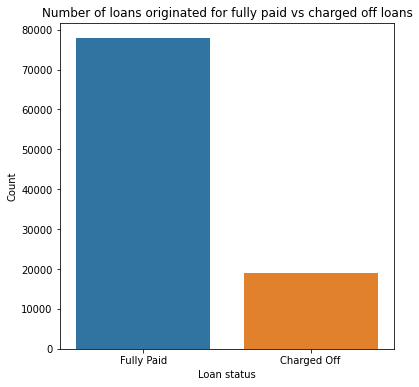

In [8]:
# plot loan status distribution
plt.figure(figsize=(6,6))
sns.countplot(x = df['loan_status'])
plt.xlabel('Loan status')
plt.ylabel('Count')
plt.title('Number of loans originated for fully paid vs charged off loans')
plt.show()


#fig = px.histogram(df, x="loan_status",width=400, height=400)
#fig.update_layout(title = 'Loan status distribution',title_x=0.5)
#fig.show()

In [11]:
loan_status_distribution = df['loan_status'].value_counts().to_frame()
loan_status_distribution = loan_status_distribution.reset_index()
loan_status_distribution.columns = ['loan_status','frequency']
loan_status_distribution

,loan_status,frequency
0,Fully Paid,77883
1,Charged Off,18956


In [12]:
df['loan_status'].value_counts(normalize=True)


Fully Paid     0.804252
Charged Off    0.195748
Name: loan_status, dtype: float64

There are 77883 fully paid accounts and 18956 charged off accounts. 80.4% of the loans are fully paid and 19.6% loans are charged off. So the data is skewed. So if we use accuracy as performance metrics, if the model predicts fully paid everytime, the accuracy will be 80%. Which is why I choose to use F1 score as performance metrics and monitor both precision and recall along with accuracy. Using confusion matrix, I will monitor the model performance on both fully paid and charged off categories. Also I will used scale_pos_weight which will be a hyperparameter to handle the data imbalance.

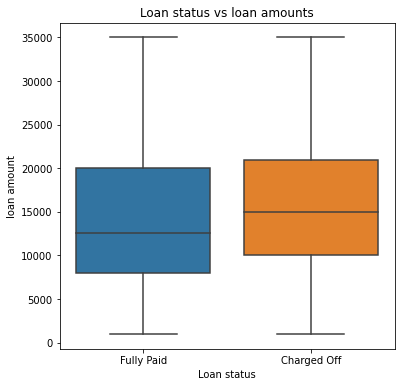

In [11]:
# Distribution of Loan Amounts by Loan Status

plt.figure(figsize=(6,6))
sns.boxplot(x="loan_status", y="loan_amnt", data=df)
plt.xlabel('Loan status')
plt.ylabel('loan amount')
plt.title('Loan status vs loan amounts')
plt.show()

#fig = px.box(df,x='loan_status',y='loan_amnt')
#fig.show()

The median loan amount of charged off accounts(15k) is a bit higher than median loan amount of fully paid accounts(12.5k).

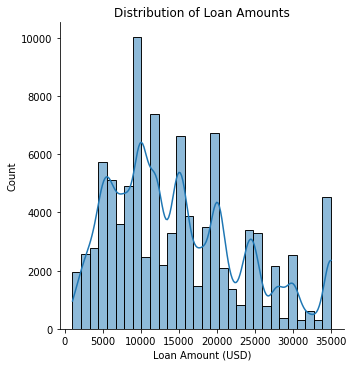

In [14]:
# plot of distribution of loan amounts
#plt.figure(figsize=(6,6))
sns.displot(df['loan_amnt'], kde=True, bins=30)
plt.xlabel('Loan Amount (USD)')
plt.ylabel('Count')
plt.title('Distribution of Loan Amounts')
plt.show()

In our data, loans of 10k$ are distributed most. 

Text(0.5, 1.0, 'Fraction Charge-Offs vs Employment Length')

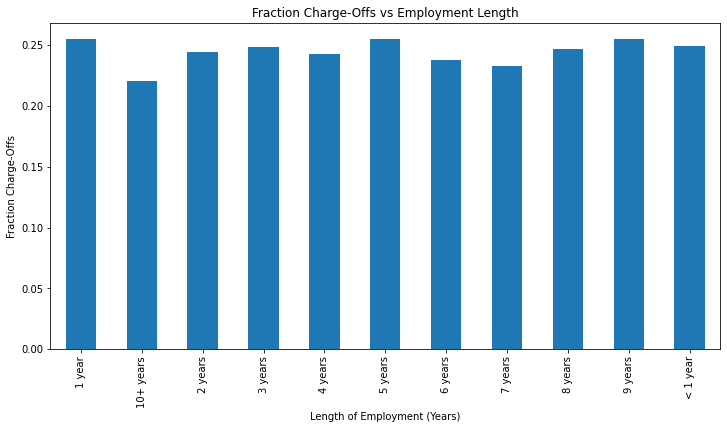

In [15]:
# plot of fraction charge offs vs employement length
yrs_paid = df[df['loan_status'] == 'Fully Paid'].groupby('emp_length').count()['loan_status']
yrs_not_paid = df[df['loan_status'] == 'Charged Off'].groupby('emp_length').count()['loan_status']
yrs_pct_paid = yrs_not_paid/yrs_paid

plt.figure(figsize=(12, 6))
yrs_pct_paid.plot(kind='bar')
plt.xlabel('Length of Employment (Years)')
plt.ylabel('Fraction Charge-Offs')
plt.title('Fraction Charge-Offs vs Employment Length')

People with over 10 plus years of employment have lowest charge off ratio. Also, people with less than 1 year of employment have highest charge off ratio. 

Text(0.5, 1.0, 'Employment Length vs number of loans')

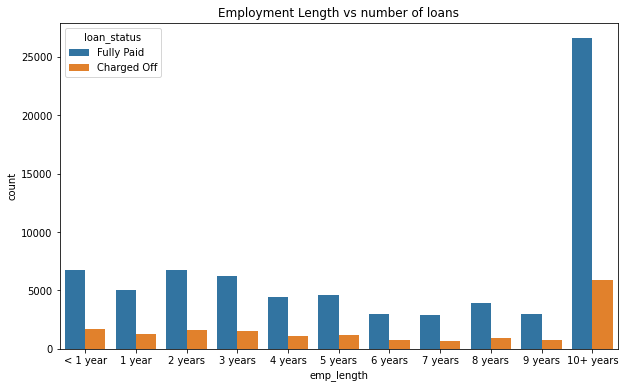

In [15]:
# plot of employement length vs loan status
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
plt.figure(figsize=(10, 6))
sns.countplot(x='emp_length', data=df, hue='loan_status', order=order)
plt.title('Employment Length vs number of loans')

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

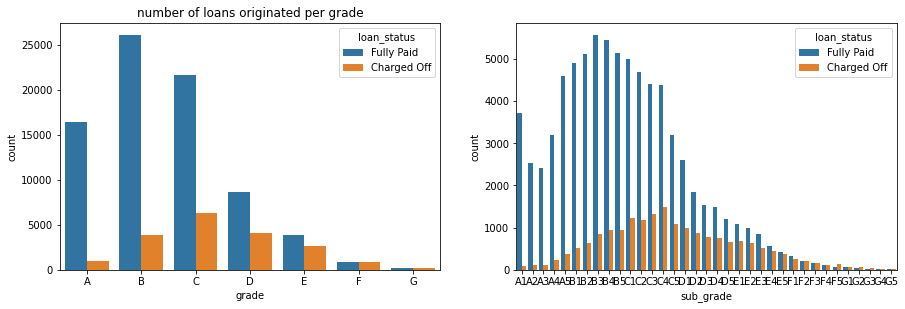

In [16]:
# grades vs loan status
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)
plt.title('number of loans originated per grade')

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)

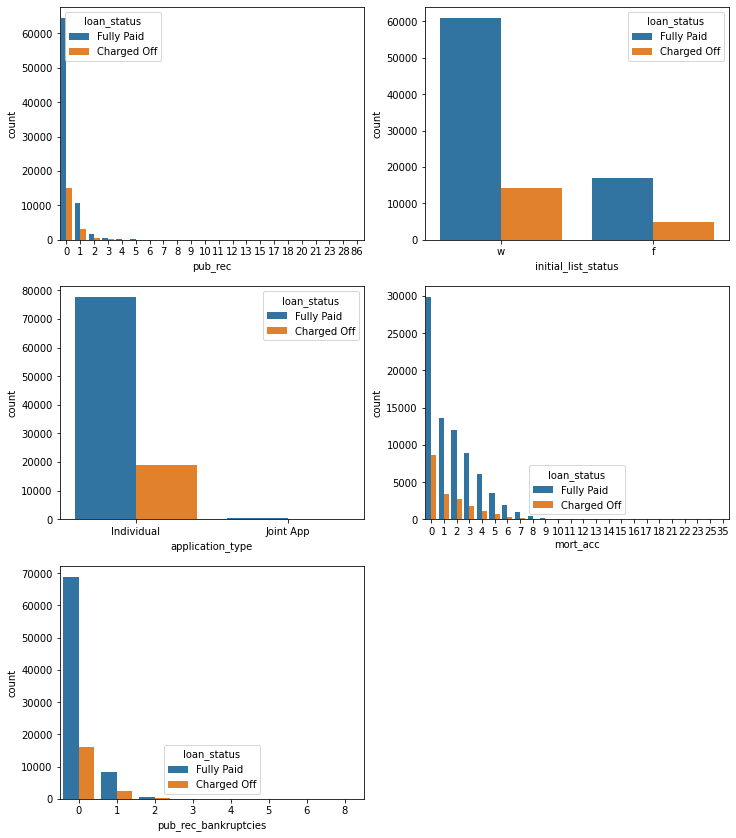

In [129]:
# plot of loan status vs features like application type.
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=df, hue='loan_status')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=df, hue='loan_status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=df, hue='loan_status')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=df, hue='loan_status')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=df, hue='loan_status')

### 2.2 Missing/Null values

Let's check missing or null values

In [16]:
missing_values_count = df.isna().sum().sort_values(ascending=False).to_frame()
missing_values_count = missing_values_count.reset_index()
missing_values_count.columns = ['feature','number of missing values']
missing_values_count.head()

,feature,number of missing values
0,next_pymnt_d,96839
1,sec_app_inq_last_6mths,96839
2,sec_app_collections_12_mths_ex_med,96839
3,sec_app_chargeoff_within_12_mths,96839
4,sec_app_num_rev_accts,96839


In [ ]:
missing_values_count['Percentage of missing values(%)'] = (missing_values_count['number of missing values']/len(df))*100

In [18]:
missing_values_count[missing_values_count['Percentage of missing values(%)'] > 90].head()

,feature,number of missing values,Percentage of missing values(%)
0,next_pymnt_d,96839,100.0
1,sec_app_inq_last_6mths,96839,100.0
2,sec_app_collections_12_mths_ex_med,96839,100.0
3,sec_app_chargeoff_within_12_mths,96839,100.0
4,sec_app_num_rev_accts,96839,100.0


We can see 38 features have over 90% of their values missing. 

14 features have 100 % missing values. Member id, next payment day are empty in all rows and 12 secondary applicant features are missing totally. So I decided to remove these 14 features. 

Also hardship based features are missing over 99% of the times. As of now I will remove all hardship related features except hardship_status feature. Hardship_status feature may have correlation with account charge off. If time permits, I will work on other hardship related features. 

If there are any previous settlement issues, then the risk involved maybe high. So I will assume 'settlement_status' as 1 if it is not null else 0.



In [19]:
high_missing_value_features = missing_values_count[missing_values_count['Percentage of missing values(%)'] > 90]['feature'].tolist()

In [20]:
high_missing_value_features.remove('settlement_status')
high_missing_value_features.remove('hardship_status')

In [21]:
df.drop(high_missing_value_features, axis=1, inplace=True)

In [22]:
print('Remaining columns count: ', len(df.columns))

Remaining columns count:  113


In [23]:
# if settlement/hardship status is not null, assign 1 else 0
df['settlement_status'] = np.where(df['settlement_status'].isna(),0,1)
df['hardship_status'] = np.where(df['hardship_status'].isna(),0,1)

### 2.3  Filter features based on data types.

In [24]:
df.dtypes.value_counts()

int64      48
float64    41
object     24
dtype: int64

There are 48 features with int and 41 features with float datatype. There are over 24 features with object datatype which can either be string or dates. 

Let's have a look at object datatypes:

In [25]:
object_dt_columns = df.columns[df.dtypes=='object'].tolist()

In [26]:
print(object_dt_columns)

['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'debt_settlement_flag']


# 3. Data preprocessing 

### 3.1 Feature generator: Convert text/string features to numericals.

In [27]:
def one_hot_encode_features(df,feature_name):
  """ 
  One hot encode string features and
  delete original string feature
  """
  one_hot = pd.get_dummies(df[feature_name])
  one_hot_col_names = one_hot.columns.to_list()
  new_one_hot_col_names = [feature_name+'_'+i for i in one_hot_col_names]
  one_hot.columns = new_one_hot_col_names
  df = pd.concat([df,one_hot], axis = 1)
  del df[feature_name]
  return df


def extract_employement_length(x):
  """ employement length varies from 0 to 10 plus years.
  if emp_length < 1, return 0.
  if emp_length > 10, return 10.
  else return corresponding length(1 to 9)
  """
  if x is np.nan:
    return 0
  elif '<' in x:
    return 0
  elif '+' in x:
    return 10
  else:
    return int(x.split()[0])
  

def text_feature_generator(df):
  """ 
  text feature generator: Extracts information from text features or
  convert categorical values to numerical counterparts.
  """

  # term feature is '36 months' or '60 months'. Strip months and convert to int.
  # Example: '36 months' -> 36, '60 months' -> 60
  df['term'] = df['term'].map(lambda x: np.int(x.split()[0]))

  # features int_rate and revol_util are as 69%, 15% etc. 
  # Strip '%' and convert it to float.
  df['int_rate'] = df['int_rate'].str.replace('%','').astype(float)
  df['revol_util'] = df['revol_util'].str.replace('%','').astype(float)

  # remove grade feature as subgrade consists of grade.
  # For example c1 has grade c, level 1.
  del df['grade']

  # label encode based on subgrade
  # We do label encoding as generally grade A loans are in general considered safer than grade B and so on. 
  sub_grades_list = df['sub_grade'].unique().tolist()
  sub_grades_list.sort()
  sub_grades_dict = {k: v for v, k in enumerate(sub_grades_list)}
  
  df['sub_grade'] = df['sub_grade'].map(lambda x: sub_grades_dict[x])

  # Remove employement title as we donot have sufficient data on which employement areas repay loan well. 
  # Maybe an area to explore later. 
  del df['emp_title']

  # Extract employement length from text
  df['emp_length'] = df['emp_length'].map(extract_employement_length)

  # one hot encode home ownership feature: mortgage, rent, own and any. 
  df = one_hot_encode_features(df,'home_ownership')

  # map loan status: 0 for fully paid and 1 for charged off.
  df['loan_status'] = df['loan_status'].map(lambda x: 0 if x == 'Fully Paid' else 1)

  # one hot encode purpose feature.
  df = one_hot_encode_features(df,'purpose')

  #df['days_between_last_date_and_loan_issuance'] =  pd.to_datetime(df['last_pymnt_d']) - pd.to_datetime(df['issue_d']) 


  # pymnt_plan is 'n' for all the rows and thus can be deleted.
  # deleted many features as they have close to 0 variance. 
  # Deleted state and zipcode as of now. Will work on it if time permits.
  # deleted last payement date as I assumed while issuing a loan, this event occurs at the end.
  df.drop(['issue_d', 'pymnt_plan','verification_status',
           'url','title','zip_code','addr_state',
           'earliest_cr_line','initial_list_status',
           'last_pymnt_d','last_credit_pull_d','debt_settlement_flag',
           'application_type', 'hardship_flag'], axis=1, inplace=True)

  return df



In [28]:
df = text_feature_generator(df)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,...,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_status,settlement_status,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
0,68446771,7200,7200,7200,36,15.77,252.32,15,0,55000.0,0,17.35,0,680,684,0,59.0,74.0,24,1,5938,69.0,43,0.0,0.0,8894.319824,8894.32,7200.00,1694.32,0.0,0.0,0.00,2602.09,774,770,0,NaN,1,0,0,...,0,2,3,4,5,35,6,8.0,3,24,0.0,0,0,3,97.7,50.0,0,1,255047,275831,6700,246447,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,68367009,14025,14025,14025,60,18.49,359.90,19,10,39000.0,0,18.00,0,675,679,1,NaN,NaN,12,0,15646,74.9,21,0.0,0.0,16341.390792,16341.39,14025.00,2316.39,0.0,0.0,0.00,12764.01,709,705,0,NaN,1,0,0,...,0,3,11,3,3,4,11,13.0,11,12,0.0,0,0,2,100.0,66.7,0,0,72286,15646,8800,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,68585839,17475,17475,17475,36,13.99,597.17,13,2,39750.0,1,23.58,0,695,699,0,27.0,NaN,7,0,10987,52.3,13,0.0,0.0,15789.650000,15789.65,8303.45,3104.20,0.0,4382.0,788.76,597.17,589,585,0,NaN,1,0,0,...,0,2,2,4,5,6,4,7.0,2,7,0.0,0,0,1,84.6,0.0,0,0,50240,32365,21000,29240,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,68577849,18000,18000,18000,60,11.99,400.31,10,10,112000.0,0,8.68,0,800,804,0,NaN,NaN,17,0,10711,15.5,27,0.0,0.0,18387.220000,18387.22,18000.00,387.22,0.0,0.0,0.00,18004.90,699,695,0,NaN,1,0,0,...,0,5,6,12,12,6,15,17.0,6,16,0.0,0,0,4,100.0,0.0,0,0,309710,36127,69800,26210,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,68587652,25000,25000,25000,36,5.32,752.87,0,1,150000.0,0,9.54,0,795,799,0,NaN,NaN,7,0,19339,42.5,18,0.0,0.0,27033.110864,27033.11,25000.00,2033.11,0.0,0.0,0.00,752.86,784,780,0,NaN,1,0,0,...,0,1,1,3,3,4,4,7.0,1,7,0.0,0,0,1,100.0,0.0,0,0,512381,44786,44000,51081,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [29]:
df.dtypes.value_counts()

int64      52
float64    43
uint8      16
dtype: int64

As we can see, using feature generator, we converted all string based features into numerical features.

### 3.2 Correlation with loan status

In [30]:
corr_matrix = df.corr()
print('Top 10 features which are highly correlated with loan_status:')
cor_df = corr_matrix["loan_status"].sort_values(ascending=False)[1:11].to_frame()
cor_df.reset_index(inplace=True)
cor_df.columns = ['Feature','correlation']
cor_df

Top 10 features which are highly correlated with loan_status:


,Feature,correlation
0,recoveries,0.522864
1,collection_recovery_fee,0.519439
2,settlement_status,0.388314
3,sub_grade,0.285864
4,int_rate,0.285575
5,term,0.178850
6,acc_open_past_24mths,0.136580
7,total_rec_late_fee,0.115847
8,num_tl_op_past_12m,0.114011
9,open_rv_24m,0.108414


As we can see recoveries is highly correlated with loan_status followed by collection recovery fee and settlement status. However events like recovery and settlement occurs if the loan payments are consistently delayed or if the account is charged off. So I decided to remove recoveries, collection recovery fees and settlement status features. Is this a good move?  Any previous recoveries and settlements often serves as alarm while giving loans. But in the data provided, we don't have  recovery information for current loans.

In [31]:
df.drop(['recoveries','collection_recovery_fee','settlement_status'], axis=1,inplace=True)

In [32]:
# correlation with loan status
new_corr_matrix = df.corr()
print('Top 10 features which are highly correlated with loan_status:')
new_cor_df = new_corr_matrix["loan_status"].sort_values(ascending=False)[1:11].to_frame()
new_cor_df.reset_index(inplace=True)
new_cor_df.columns = ['Feature','correlation']
new_cor_df

Top 10 features which are highly correlated with loan_status:


,Feature,correlation
0,sub_grade,0.285864
1,int_rate,0.285575
2,term,0.178850
3,acc_open_past_24mths,0.136580
4,total_rec_late_fee,0.115847
5,num_tl_op_past_12m,0.114011
6,open_rv_24m,0.108414
7,dti,0.096661
8,open_il_24m,0.095335
9,inq_last_6mths,0.092867


Correlation heatmap: 



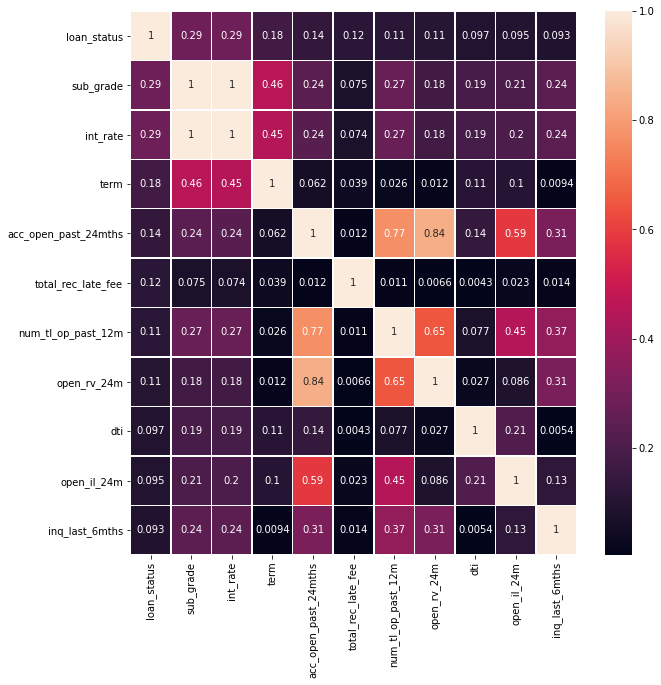

In [33]:
# correlation heatmap 
highly_cor_features =['loan_status'] + new_cor_df['Feature'].values.tolist()
df_cor = df[highly_cor_features]
corr = df_cor.corr()
fig, ax = plt.subplots(figsize=(10,10))    
print('Correlation heatmap:','\n')     
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True
            , linewidths=.5, ax=ax)


### 3.3 Treating null values

In [34]:
# Check columns with null values.
df.columns[df.isnull().any()]

Index(['dti', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util',
       'mths_since_last_major_derog', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'inq_fi', 'total_cu_tl', 'inq_last_12m', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_rev_accts', 'num_tl_120dpd_2m',
       'percent_bc_gt_75'],
      dtype='object')

In [35]:

def treat_missing_values(df):

  # feature dti: ratio of debt to income. num_missing = 2
  df['dti'].fillna(0, inplace=True)

  # Replace missing values of all months related features with 0
  months_features = ['mths_since_last_delinq','mths_since_last_record',
   'mths_since_last_major_derog','mths_since_rcnt_il',
   'inq_last_12m','mo_sin_old_il_acct','mths_since_recent_bc',
   'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
   'mths_since_recent_revol_delinq','bc_open_to_buy', 'bc_util',
   'num_rev_accts','num_tl_120dpd_2m', 'percent_bc_gt_75']

  df[months_features]=df[months_features].fillna(0)

  #revolving utilization. num_missing = 37
  df['revol_util']=df['revol_util'].fillna(0)


  accounts_months = ['open_acc_6m','open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m','open_rv_12m', 'open_rv_24m',
       'total_bal_il','il_util','max_bal_bc','all_util', 'inq_fi',
       'total_cu_tl','last_pymnt_amnt']

  pymnt_recieved = ['total_rec_late_fee', 'total_rec_prncp', 'total_rec_int',
                    'total_pymnt','total_pymnt_inv','out_prncp_inv','out_prncp']

  df.drop(accounts_months, axis=1,inplace=True)
  df.drop(pymnt_recieved, axis=1,inplace=True)

  return df

In [36]:
# Check columns with null values.

df = treat_missing_values(df)
df.columns[df.isnull().any()]

Index([], dtype='object')

# 4. Feature engineering

I observed many columns are identical or 'almost' identical. For example features 'loan_amnt' is exactly same as 'funded_amnt' and almost identical to 'funded_amnt_inv'. So remove highly correlated variables as they make model highyly sensitive to small fluctuations in the data.

In [37]:
# check if loan_amnt feature is same as funded_amnt
df['loan_amnt'].equals(df['funded_amnt'])

True

In [38]:

def remove_highly_correlated_feature(df, threshold = 0.97):
  """ Identify highly correlay features.
   Have to modify this as it is removing useful features like fico_range_high,
   sub_grade.
   """
  # Create correlation matrix
  corr_matrix = df.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find features with correlation greater than 0.97
  to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]

  # Drop features 
  df.drop(to_drop, axis=1, inplace=True)

  return df


to_drop = ['funded_amnt', 'funded_amnt_inv',]
df.drop(to_drop, axis=1, inplace=True)


In [39]:
def standard_scaler(df,feature_name):
  """
  Scale values- remove mean and standardize with variance.
  """
  autoscaler = StandardScaler()
  df[feature_name] = autoscaler.fit_transform(df[feature_name])
  return df


In [40]:
scale_columns = ['fico_range_low','fico_range_high','last_fico_range_high','last_fico_range_low']

#features = df[scale_columns]
#scaler = StandardScaler().fit(features.values)
#features = scaler.transform(features.values)
#df[scale_columns] = features


In [41]:
# remove id feature.
df.drop('id',axis=1,inplace=True)

### Train, val and test split

Generate train, validation and test datasets

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [43]:
# Create X(input) and y(output) features.
y = df['loan_status'] #target label
X = df.drop('loan_status',axis=1)

# train dataset
X_train, X_val_test, y_train, y_val_test  = train_test_split(X,y, stratify=y, 
                                   random_state=0,test_size = 0.2)
#validation and test datasets
X_test, X_val, y_test, y_val = train_test_split(X_val_test,y_val_test, 
                                                stratify=y_val_test,
                                                random_state=0,test_size = 0.2)


In [44]:
# Min-max scaler: Standardize the input variables using min-max scaler.
# Min-max scaler is performing better than standard-scaler on this dataset. 

def min_max_scaler(train,val,test):
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)
    return train,val,test


X_train,X_val,X_test = min_max_scaler(X_train,X_val,X_test)

# 5. ML modeling

My idea was to start small and build a logistic regression model and see how it performs on the data. This serves as baseline model. Later depending on the performance, I will move to more complex models like xgboosting which performs well on tabular data format. Depending on it’s performance, I will try to do hyperparameter tuning or try out different techniques like doing advanced feature engineering like using domain knowledge to create more features etc to improve the model performance. 

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

### 5.1 Logistic regression

Let's build logistic regression and see how the model is performing on the train and test datasets. This serves as a baseline model to evaluate the performance.

In [46]:

def performance_evaluator(y_true, y_pred, model_name):

  """
  Evaluate model performance
  """

  print(model_name,'results:','\n')

  acc = accuracy_score(y_true,y_pred) # accuracy
  acc = round(acc*100,4)
  print('Accuracy of',model_name,':',acc,'%')

  #f1 = f1_score(y_true,y_pred) # f1 score
  #f1 = round(f1,4)
  #print('F1 score of',model_name,':',f1,'\n')

  print('classification report: ') # classification report
  cr = classification_report(y_true,y_pred,target_names=['fully paid', 'charged off'])
  print(cr,'\n')

  cm = confusion_matrix(y_true,y_pred) # confusion matrix
  print('confusion matrix: ','\n',cm)
  

In [ ]:
# instantiate the model
lr = LogisticRegression(max_iter=12000)
lr.fit(X_train,y_train) # fit the training data and train the model

lr_train_predictions = lr.predict(X_train) # predict on train data
lr_test_predictions = lr.predict(X_test) # predict on test data

In [95]:
performance_evaluator(y_test, lr_test_predictions, 'Logistic regression')

Logistic regression results: 

Accuracy of Logistic regression : 89.5766 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.93      0.95      0.94     12461
 charged off       0.76      0.69      0.72      3033

    accuracy                           0.90     15494
   macro avg       0.84      0.82      0.83     15494
weighted avg       0.89      0.90      0.89     15494
 

confusion matrix:  
 [[11782   679]
 [  936  2097]]


As we can see from above results, logistic regression is performing decently on the data. We got an accuracy of 89%. It is predicting fully paid accounts well(f1 score of 0.94)

We can notice, out of 12461 fully paid accounts, the model is able to predict 11782 correctly. Where as out of 3033 charged off accounts, it is able to predict 2097 well and it missed 936 accounts. It resulted in recall of 0.69 for charged off accounts. To improve on recall, I tried out more complex models.

### 5.2 SVM

Let's build SVM and see how the model is performing on the train and test datasets. 

In [96]:
# instantiate the model
svm = SVC()
svm.fit(X_train, y_train)  # fit the training data and train the model

svm_train_predictions = svm.predict(X_train) # predict on train data
svm_test_predictions = svm.predict(X_test) # predict on test data

In [97]:
performance_evaluator(y_test, svm_test_predictions, 'SVM')

SVM results: 

Accuracy of SVM : 89.6024 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.93      0.94      0.94     12461
 charged off       0.75      0.70      0.73      3033

    accuracy                           0.90     15494
   macro avg       0.84      0.82      0.83     15494
weighted avg       0.89      0.90      0.89     15494
 

confusion matrix:  
 [[11746   715]
 [  896  2137]]


### 5.3 KNN

Let's build KNN and see how the model is performing on the train and test datasets. 

In [98]:
# instantiate the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)  # fit the training data and train the model

#knn_train_predictions = knn.predict(X_train) # predict on train data
knn_test_predictions = knn.predict(X_test) # predict on test data

In [99]:
performance_evaluator(y_test, knn_test_predictions, 'knn')

knn results: 

Accuracy of knn : 84.2197 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.86      0.96      0.91     12461
 charged off       0.69      0.35      0.47      3033

    accuracy                           0.84     15494
   macro avg       0.77      0.66      0.69     15494
weighted avg       0.83      0.84      0.82     15494
 

confusion matrix:  
 [[11975   486]
 [ 1959  1074]]


# 5.4 Xgboosting

Let's train the data on xgboosting

In [100]:
# instantiate the model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)  # fit the training data and train the model

xgb_train_predictions = xgb.predict(X_train) # predict on train data
xgb_test_predictions = xgb.predict(X_test) # predict on test data

In [101]:
performance_evaluator(y_test, xgb_test_predictions, 'Xgboosting')

Xgboosting results: 

Accuracy of Xgboosting : 89.6412 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.94      0.93      0.94     12461
 charged off       0.73      0.74      0.74      3033

    accuracy                           0.90     15494
   macro avg       0.83      0.84      0.84     15494
weighted avg       0.90      0.90      0.90     15494
 

confusion matrix:  
 [[11632   829]
 [  776  2257]]


With vanilla **Xgboosting** model without any addons like hyperparameter tuning, feature engineering or regularization, the accuracy is 89.6% and F1 score on fully paid accounts is 0.94 and recall on charged off accounts improved significantly to 0.74. 

We can notice, out of 12461 good accounts, the model is able to predict all 11632 correctly. Out of 3033 charged off accounts, it is able to predict 2257 well and it missed 776 accounts which is significant improvement over other models logistic regression, SVM. 

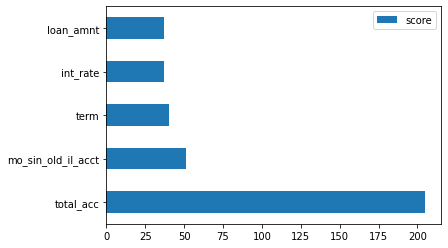

In [102]:
# Feature importance
feature_important = xgb.get_booster().get_score(importance_type='weight')

l = df.columns.to_list()
new_l = {i:v for i,v in enumerate(l)}
new_f = {}
for i in feature_important:
  cur = i
  cur = int(cur.replace('f',''))
  new_f[new_l[cur]] = feature_important[i]


keys = list(new_f.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.head().plot(kind='barh')

It's pretty intersting to see that total accounts, loan term and interst rates are affecting the model performance more.

### 5.5 Xgboosting with polynomial features

In [47]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly_2 = poly.fit_transform(X_train)
X_test_poly_2 = poly.transform(X_test)

In [48]:
# instantiate the model
xgb_poly = XGBClassifier()
xgb_poly.fit(X_train_poly_2, y_train)  # fit the training data and train the model

xgb_test_predictions = xgb_poly.predict(X_test_poly_2) # predict on test data

In [49]:
performance_evaluator(y_test, xgb_test_predictions, 'Xgboosting with polynomial degree 2')

Xgboosting with polynomial degree 2 results: 

Accuracy of Xgboosting with polynomial degree 2 : 89.6992 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.94      0.93      0.94     12461
 charged off       0.73      0.74      0.74      3033

    accuracy                           0.90     15494
   macro avg       0.84      0.84      0.84     15494
weighted avg       0.90      0.90      0.90     15494
 

confusion matrix:  
 [[11648   813]
 [  783  2250]]


# 6. Hyperparameter tuning

In [ ]:
# parameters for hyperparameter tuning.
params_grid = {
    'n_estimators': [100, 200,300],
    'learning_rate': [0.05,0.1,1],
    'max_depth':[5,6,7,8],
    'min_child_weight':[3,4,5],
    'gamma': [0.4,0.5,0.6],
    'scale_pos_weight': [5,8,10]
}


xgb = XGBClassifier()
xgb_cv = GridSearchCV(xgb, params_grid)
xgb_cv.fit(X_train, y_train)
xgb_cv_test_predictions = xgb_cv.predict(X_test) # predict on test data

In [107]:
performance_evaluator(y_test, xgb_cv_test_predictions, 'Xgboosting with parameter tuning')

Xgboosting with parameter tuning results: 

Accuracy of Xgboosting with parameter tuning : 93.1457 %
classification report: 
              precision    recall  f1-score   support

  fully paid       0.95      0.96      0.96     12461
 charged off       0.83      0.81      0.82      3033

    accuracy                           0.93     15494
   macro avg       0.89      0.89      0.89     15494
weighted avg       0.93      0.93      0.93     15494
 

confusion matrix:  
 [[11968   493]
 [  569  2464]]


# 7. Conclusion



The main moto of the problem is to predict the loan charge off accounts. The data has 100k loans originated between oct 2015 and dec 2015. The loans which are paid properly are labelled ‘Fully paid’ and default loans are labelled as ‘charged off’. I found 80% of the loans are fully paid and the rest are charged off accounts. So I used scale_pos_weight parameter later in Xgboosting to handle the data imbalance. I have done some Exploratory data analysis to get an overview of the data. I have built the model as a binary classification model where 1 refers charge off and 0 refers the account will be fully paid. I observed different distributions of the data, how they are responding to the loan status, correlation between different input features and output feature etc. Based on these, I moved to data preprocessing. There are 150 features. Of these I removed multiple features initially. Over 14 features have 100% missing/null values. Many features have zero variance or close to zero variance. I removed such features. Many features are related to closing events or later events like loan recovery, loan settlement status etc which are also removed. If I include one of the features related to later events like recovery amount, I am getting close to perfect predictions (accuracy of 99% and F1 score of 0.98). 

As next steps, I generated a text feature generator which extracts features from text data. Some of the things done are like removing special characters like ‘%’ symbol in interest rate, ‘>, <, +’ symbols in employment length (+10 years) etc. I label encoded few features which have ordinal relationship like grades, subgrades. Grade A is considered better than grad F. I one hot encoded some features which doesn’t have any ordinal relationship like purpose of loan origination (debt consolidation, car loan etc.). Also, I removed features which are multicollinear. I imputed some missing values in features with appropriate values.

Later I moved to model building. I used logistic regression as a baseline model using which we got an accuracy of 89% and macro F1 score of 0.82. One thing I noticed is the model is predicting well for fully paid accounts whereas it is stumbling on predicting charged off accounts perfectly. So I decided to concentrate on recall value of charged off accounts. The recall on charged off accounts using regression is 0.69. I then tried out SVM which performed slightly better than logistic regression model. Knn performed worse than both the models because of curse of dimensionality(recall is 0.35). 

I then choose Xgboosting which often works well on tabular data. It performs well due to multiple factors like building the tree in more regularized manner, using ensemble of models(boosting), sparse awareness and weighted quantile search. Vanilla Xgboosting perfomed better than logistic regression, SVM and knn. The accuracy is same(89%) but macro f1 score improved to 0.84 and the recall on charged off accounts improved to 0.74. It is increased by 0.5 when compared to logistic regression. So I decided to work more on Xgboosting and I initially tried polynomial features with a degree of 2. In general, the interaction terms of polynomials boost the performance. But on our data, I couldn’t find much difference. So I later moved to hyperparameter tuning. I used grid search cv. I finetuned multiple parameters like learning rate, max tree depth, minimum child weight etc. I also finetuned scale_pos_weight to handle data imbalance. Using tuning, the accuracy improved from 89% to 93%. Macro F1 score improved from 0.84 to 0.88. Recall on charged off accounts increased from 0.74 to 0.81 which is a significant improvement.  

There is still lots of scope for model performance improvement. But given time constraints, I stopped going further. These are some of the places of improvement:

1. I removed missing features above threshold of 0.97. I would love to see if there are any patterns in these missing features. They may have important relations with the output data.

2. Use Bayesian optimization instead of grid search cv to perform hyperparameter tuning. But in general Bayesian optimization takes more time. Also I want to try out more broad range of 
hyperparameters. Due to time constraints, I limited to basic search. 
3.	Do better feature engineering. There are over 150 features. Feature engineering will be time consuming, but proper feature engineering will almost always improve the model performance. I would love to go over each feature and see how to use it better in model building. I haven’t used any domain based knowledge and it often helps in building better models.

4. Use neural network variants and see whether they perform better than traditional ML models like regression and boosting. Building neural network variant from scratch will take significant amount of time, so I limited to xgboosting.

5.	Also, I think more data might have been better. Many features seem to be very close between fully paid and charged off accounts. So more data might have provided better signal or distinguished what traits of an account will more likely to be charged off. 
